In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import scipy.stats

In [2]:
!whoami
!date

ndbs
Tue Mar 24 11:14:44 PDT 2020


# Goal: Determine reasonable distributions to model uncertainty in coverage data (i.e. what % of the population gets fortified food)

The idea here is that if the variance of a [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) is small enough, then it looks like a very narrow normal distribution centered at its mean. (Hmm, what exactly is the proof of that?)

Documentation: [scipy.stats.beta](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html)

In [3]:
def beta_a_b_from_mean_var(mean, variance):
    if mean <= 0 or mean >= 1:
        raise ValueError("Mean must be in the interval (0,1)")
    if variance >= mean*(1-mean):
        raise ValueError("Variance too large")
        
    a = mean*(mean*(1-mean)/variance - 1)
    b = (1-mean)*(mean*(1-mean)/variance - 1)
    return a, b

In [4]:
def normal_stdev_from_mean_quantile(mean, quantile, quantile_rank):
    # q = mu + q'*sigma, where q' is the std normal quantile
    # and q is the transformed quantile, so sigma = (q-mu)/q'
    return (quantile - mean) / scipy.stats.norm().ppf(quantile_rank)

In [5]:
def beta_from_mean_approx_quantile(mean, approx_quantile, quantile_rank):
    """
    Returns a scipy.stats Beta distribution with the specified mean and a
    quantile of rank quantile_rank approximately equal to approx_quantile.
    This is achieved by specifying that the variance of the Beta distribution
    is equal to the variance of a normal distribution with the same mean and
    the specified quantile.
    """
    variance = normal_stdev_from_mean_quantile(mean, approx_quantile, quantile_rank)**2
    a,b = beta_a_b_from_mean_var(mean, variance)
    return scipy.stats.beta(a,b)

## Wheat flour fortification coverage data

Data is from Table 4 in:

Grant J Aaron, Valerie M Friesen, Svenja Jungjohann, Greg S Garrett, Lynnette M Neufeld, Mark Myatt. _Coverage of Large-Scale Food Fortification of Edible Oil, Wheat Flour, and Maize Flour Varies Greatly by Vehicle and Country but Is Consistently Lower among the Most Vulnerable: Results from Coverage Surveys in 8 Countries_. https://doi.org/10.3945/jn.116.245753

India (Rajasthan)

6.3 (4.8, 7.9)

7.1 (5.6, 9.1)

83.2 (79.5, 86.5)

Nigeria (Kano)

22.7 (20.0, 25.5)

83.8 (81.4, 86.2)

83.9 (81.5, 86.3)

Nigeria (Lagos)

5.4 (3.8, 6.9)

13.8 (11.5, 16.1)

14.2 (11.8, 16.5)

### Create a dataframe to store coverage data

In [6]:
coverage_levels = ['eats_fortified', 'eats_fortifiable', 'eats_vehicle']
coverage_stats = ['mean', 'lower', 'upper']

coverage_df = pd.DataFrame(
    [
        [6.3, 4.8, 7.9, 7.1, 5.6, 9.1, 83.2, 79.5, 86.5],
        [22.7, 20.0, 25.5, 83.8, 81.4, 86.2, 83.9, 81.5, 86.3],
        [5.4, 3.8, 6.9, 13.8, 11.5, 16.1, 14.2, 11.8, 16.5],
    ],
    index = ['India (Rajasthan)', 'Nigeria (Kano)', 'Nigeria (Lagos)'],
    columns = pd.MultiIndex.from_product([coverage_levels, coverage_stats])
)
coverage_df

eats_fortified             eats_fortifiable              \
                            mean lower upper             mean lower upper   
India (Rajasthan)            6.3   4.8   7.9              7.1   5.6   9.1   
Nigeria (Kano)              22.7  20.0  25.5             83.8  81.4  86.2   
Nigeria (Lagos)              5.4   3.8   6.9             13.8  11.5  16.1   

                  eats_vehicle              
                          mean lower upper  
India (Rajasthan)         83.2  79.5  86.5  
Nigeria (Kano)            83.9  81.5  86.3  
Nigeria (Lagos)           14.2  11.8  16.5

## Try drawing a Beta distribution for 'eats_fortified' in India

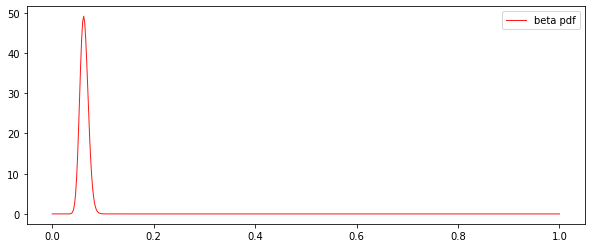

In [7]:
# India
mean = 6.3/100
q_975 = 7.9/100
quantile_rank = 0.975

variance = normal_stdev_from_mean_quantile(mean, q_975, quantile_rank)**2
a,b = beta_a_b_from_mean_var(mean, variance)

fig, ax = plt.subplots(1,1, figsize = (10,4))

x = np.linspace(0,1, 500)
ax.plot(x, scipy.stats.beta.pdf(x, a, b), 'r-', lw=1, alpha=0.9, label='beta pdf')
ax.legend()

plt.show()

### Check some distribution parameters to make sure everything looks good

In [8]:
#See what a, b, mean, and variance were
print(a,b)
print(mean,variance)

55.74248752186281 829.0589017140549
0.063 6.664134953651346e-05


In [9]:
# Check 1st-4th moments and 95% uncertainty interval
beta = beta_from_mean_approx_quantile(0.063, 0.079, 0.975)
print(beta.stats(moments='mvsk'))
print(beta.interval(.95))

(array(0.063), array(6.66413495e-05), array(0.24145887), array(0.08059681))
(0.04795889742135568, 0.07991041987700398)


In [10]:
# Check the standard deviation
normal_stdev_from_mean_quantile(mean, q_975, 0.975)

0.008163415310794463

In [11]:
# Check that the variance matches second statistic above
_**2

6.664134953651346e-05

In [12]:
# Check that the .025 and .975 quantiles match the interval above
print(beta.ppf(.025), beta.ppf(.975))

0.0479588974213558 0.07991041987700398


## Draw plots of the Beta distributions for the three locations

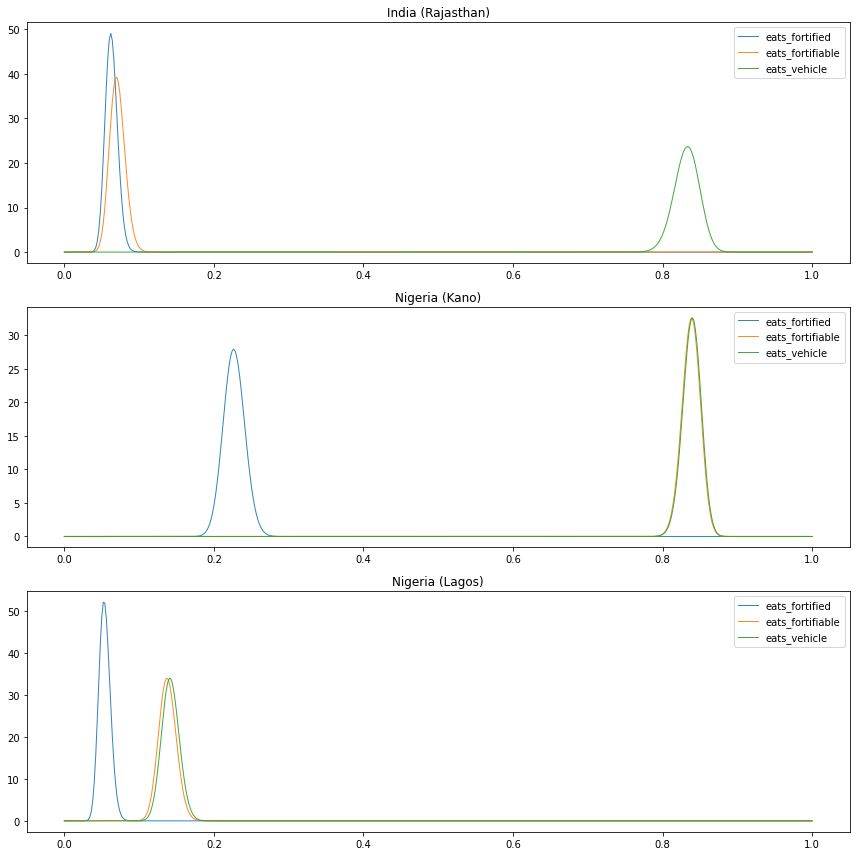

In [13]:
fig, axs = plt.subplots(3,1, figsize = (12,12))

for i,ax in enumerate(axs.flatten()):
    
    location = coverage_df.index[i]
    x = np.linspace(0,1, 500)
    
    for c in coverage_levels:
        
        mean = coverage_df.loc[location, (c,'mean')] / 100
        q_975 = coverage_df.loc[location, (c,'upper')] / 100
        beta_dist = beta_from_mean_approx_quantile(mean, q_975, 0.975)
        
        ax.plot(x, beta_dist.pdf(x),lw=1, alpha=0.9, label=c)
        ax.set_title(location)
        ax.legend()

fig.tight_layout()

# Need to save figure before calling .show(), or the file won't have the grahps
plt.savefig("coverage_india_nigeria.svg")
plt.show()